_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders


# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index.

In [45]:
'''T1. Import DataFrame `df`'''

import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date'], index_col='game_date')
# YOUR CODE HERE


**Task 1 Testing**

In [46]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [47]:
"""T2. Create new feature"""

# YOUR CODE HERE
df['shots_made_so_far'] = df.groupby('game_id')['shot_made_flag'].cumsum() - df['shot_made_flag']

**Task 2 Test**

In [49]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [ ]:
'''T3. Create `X` and `y`.'''
# YOUR CODE HERE

In [50]:
df.drop(columns=['player_name','seconds_remaining','loc_x','loc_y','game_id', 'game_event_id'], inplace=True)
df[['period', 'action_type', 'shot_type',	'shot_zone_basic',	'shot_zone_area',	'shot_zone_range','shot_made_flag', 'htm',	'vtm',	'season_type']] = df[['period', 'action_type', 'shot_type',	'shot_zone_basic',	'shot_zone_area',	'shot_zone_range','shot_made_flag', 'htm',	'vtm',	'season_type']] = df[['period', 'action_type', 'shot_type',	'shot_zone_basic',	'shot_zone_area',	'shot_zone_range','shot_made_flag', 'htm',	'vtm',	'season_type']] = df[['period', 'action_type', 'shot_type',	'shot_zone_basic',	'shot_zone_area',	'shot_zone_range','shot_made_flag', 'htm',	'vtm',	'season_type']].astype('category')

In [63]:
# df['shot_zone_range'].unique()

['24+ ft.', '16-24 ft.', '8-16 ft.', 'Less Than 8 ft.', 'Back Court Shot']
Categories (5, object): ['16-24 ft.', '24+ ft.', '8-16 ft.', 'Back Court Shot', 'Less Than 8 ft.']

In [ ]:
# shot_range_map = {'24+ ft.':3, '16-24 ft.':2, '8-16 ft.':1, 'Less Than 8 ft.':0, 'Back Court Shot':4}
# df['shot_zone_range'] = df['shot_zone_range'].map(shot_range_map)

In [53]:
X = df.drop(columns=['shot_made_flag'])
y = df['shot_made_flag']

**Task 3 Test**

In [54]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.'

**Task 4:** Divide your dataset into training, validation, and test sets.

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [57]:
'''T4. Create training and val'''
# YOUR CODE HERE
mask_train = X.index < '2017-07-01'
mask_test = X.index > '2018-10-01'
mask_val = (X.index > '2017-10-01') & (X.index < '2018-09-01')
X_train, y_train = X[mask_train], y[mask_train]
X_test, y_test = X[mask_test], y[mask_test]
X_val, y_val = X[mask_val], y[mask_val]

**Test 4**

In [58]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [60]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [61]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [66]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.ensemble import RandomForestClassifier


In [79]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

# YOUR CODE HERE
model = make_pipeline(
    OrdinalEncoder(cols=['period', 'season_type']),
    BinaryEncoder(cols=['action_type', 'shot_type', 'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'htm', 'vtm']),
    RandomForestClassifier(n_estimators=8, max_depth=4, n_jobs=-1, random_state=1948)
)
model.fit(X_test, y_test)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['period', 'season_type'],
                                mapping=[{'col': 'period',
                                          'data_type': CategoricalDtype(categories=[1, 2, 3, 4, 5, 6], ordered=False),
                                          'mapping': 1.0    1
2.0    2
3.0    3
4.0    4
5.0    5
NaN   -2
dtype: int64},
                                         {'col': 'season_type',
                                          'data_type': CategoricalDtype(categories=['Playoffs', 'Regular Season'], ordered=False),
                                          'mapping': Regular Season    1...
                                        {'col': 'vtm',
                                         'mapping':      vtm_0  vtm_1  vtm_2  vtm_3  vtm_4
 1       0      0      0      0      1
 2       0      0      0      1      0
 3       0      0      0      1      1
 4       0      0      1      0      0
 5       0      0      1      0      1
 6       0      0      1      1      0
 7       0      0      1      1      1
 8       0      1      0      0      0
 9       0      1      0      0      1
 10      0      1      0      1      0
 11      0      1      0      1      1
 12      0      1      1      0      0
 13      0      1      1      0      1
 14      0      1      1      1      0
 15      0      1      1      1      1
 16      1      0      0      0      0
 17      1      0      0      0      1
 18      1      0      0      1      0
 19      1      0      0      1      1
 20      1      0      1      0      0
 21      1      0      1      0      1
 22      1      0      1      1      0
 23      1      0      1      1      1
 24      1      1      0      0      0
 25      1      1      0      0      1
 26      1      1      0      1      0
 27      1      1      0      1      1
-1       0      0      0      0      0
-2       0      0      0      0      0}])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, n_estimators=8, n_jobs=-1,
                                        random_state=1948))])

**Task 6 Testing**

In [68]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [81]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.6123996029239238
Validation Accuracy Score: 0.6053082191780822


**Task 7 Test**

In [70]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`.
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [82]:
'''T8. Tune model.'''

# YOUR CODE HERE
test_acc = model.score(X_test, y_test)
print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.6489174956114687


**Task 8 Testing**

In [83]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

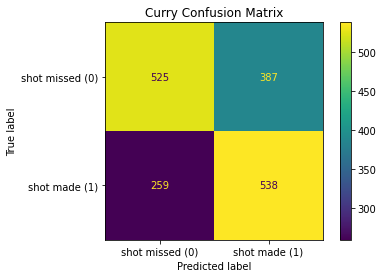

In [84]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
instructor_precision = 538 / (538 + 387)
instructor_recall = 538 / (538 + 259)
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


**Task 9 Testing**

In [85]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**.

This task will not be autograded - but it is part of completing the challenge.

In [88]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

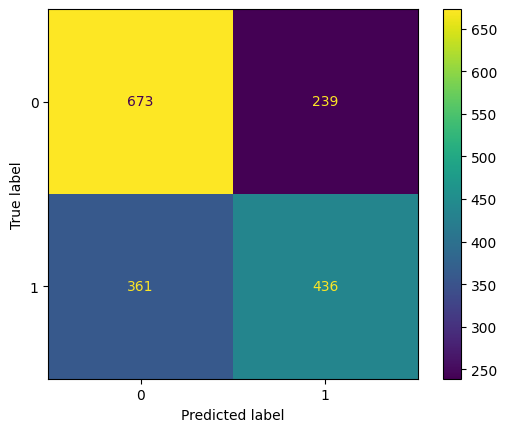

In [87]:
'''T10. Plot ROC curve.'''
# YOUR CODE HERE
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [89]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       912
           1       0.65      0.55      0.59       797

    accuracy                           0.65      1709
   macro avg       0.65      0.64      0.64      1709
weighted avg       0.65      0.65      0.65      1709

